---
title: "forecasting tutorial"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

We will see now a simple example of forecasting, using two simple models. The idea here is to learn the most basic concepts. Many of the advanced models would require a lot of time to cover, and this is not our goal here.

## darts

We will use the darts library, which is a time series library that provides a lot of tools for forecasting.

To install it, type the following command on your terminal:

```conda install -c conda-forge -c pytorch u8darts-all```


In [1]:
#| code-summary: "import stuff"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import LinearRegressionModel
from darts.models import AutoARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# %matplotlib widget

How to choose the best model? Let's take a look at the following table:  
<https://unit8co.github.io/darts/#forecasting-models>

## The data

We will work with dendrometer data. Dendrometers are instruments that measure the diameter of trees. We will forecast the diameter of a tree using the data from the dendrometer, and other atmospheric variables, such as temperature, relative humidity, rainfall and solar radiation.

In [2]:
#| code-summary: "load data as a dataframe"
df = pd.read_csv('dendrometer_sample.csv', parse_dates=['time'], index_col='time')
df

,dend,T,RH,vpd,rain,PAR
time,,,,,,
2016-10-01 00:15:00,4.988874,17.166667,29.666667,1.376667,0.0,0.000
2016-10-01 00:45:00,4.989843,17.166667,26.666667,1.433333,0.0,0.000
2016-10-01 01:15:00,4.989843,17.666667,23.666667,1.543333,0.0,0.000
2016-10-01 01:45:00,4.987906,17.533333,23.666667,1.530000,0.0,0.000
2016-10-01 02:15:00,4.994685,18.300000,21.333333,1.653333,0.0,0.000
...,...,...,...,...,...,...
2022-06-15 10:45:00,44.283024,27.066667,36.666667,2.263333,0.0,2019.211
2022-06-15 11:15:00,44.276245,27.633333,37.333333,2.316667,0.0,2078.081
2022-06-15 11:45:00,44.276245,27.966667,37.000000,2.376667,0.0,2098.697


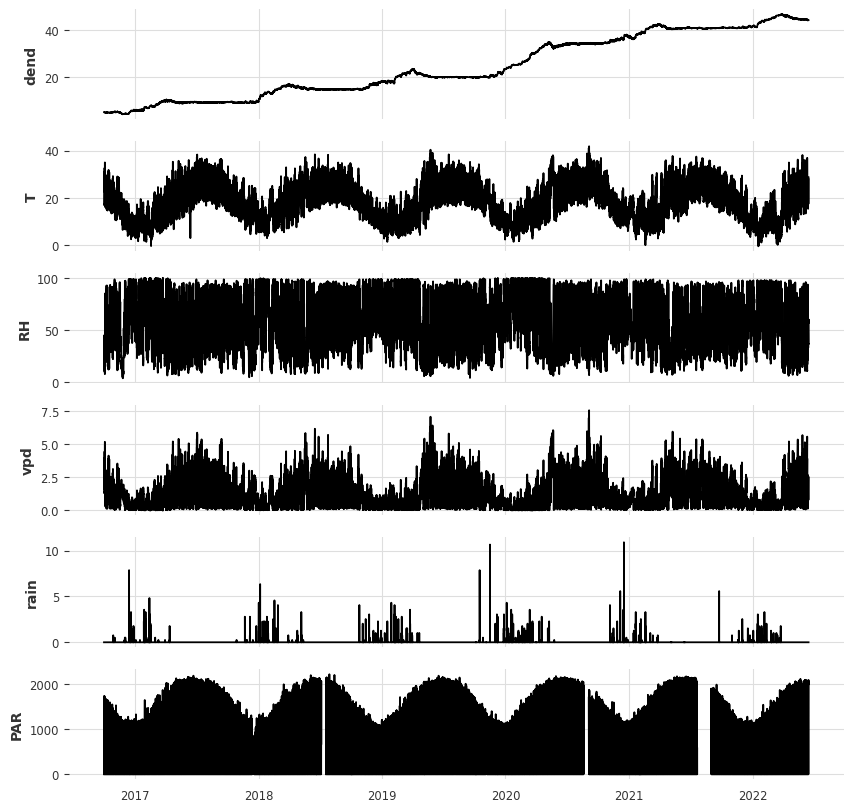

In [3]:
#| code-summary: "plot all columns"
columns = df.columns

fig, ax = plt.subplots(len(columns), 1, figsize=(10, 10), sharex=True)
for i, column in enumerate(columns):
    ax[i].plot(df.index, df[column])
    ax[i].set_ylabel(column)

In [4]:
#| code-summary: "resample data to 1H, interpolate missing values, and convert to darts TimeSeries object"
df = df.resample('1H').mean().interpolate()
data = TimeSeries.from_dataframe(df)
data_jan = TimeSeries.from_dataframe(df['2021-01-01':'2021-01-30'])
data_jun = TimeSeries.from_dataframe(df['2021-06-01':'2021-06-30'])
data

/var/folders/hg/vb3h0zd17wn6zfm9q5zk3pbw0000gn/T/ipykernel_24374/3828487745.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').mean().interpolate()


<TimeSeries (DataArray) (time: 50005, component: 6, sample: 1)> Size: 2MB
array([[[4.98935890e+00],
        [1.71666667e+01],
        [2.81666667e+01],
        [1.40500000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[4.98887491e+00],
        [1.76000000e+01],
        [2.36666667e+01],
        [1.53666667e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[4.99420071e+00],
        [1.84000000e+01],
        [2.11666667e+01],
        [1.66666667e+00],
        [0.00000000e+00],
        [0.00000000e+00]],
...
       [[4.42835064e+01],
        [2.69000000e+01],
        [3.70000000e+01],
        [2.23166667e+00],
        [0.00000000e+00],
        [1.97888400e+03]],

       [[4.42762451e+01],
        [2.78000000e+01],
        [3.71666667e+01],
        [2.34666667e+00],
        [0.00000000e+00],
        [2.08838900e+03]],

       [[4.42743072e+01],
        [2.86000000e+01],
        [3.76666667e+01],
        [2.43833333e+00],
        [0.00000000e+00],
        [2.03524600e+03]]])
Coordinates:
  * time       (time) datetime64[ns] 400kB 2016-10-01 ... 2022-06-15T12:00:00
  * component  (component) object 48B 'dend' 'T' 'RH' 'vpd' 'rain' 'PAR'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='time'>

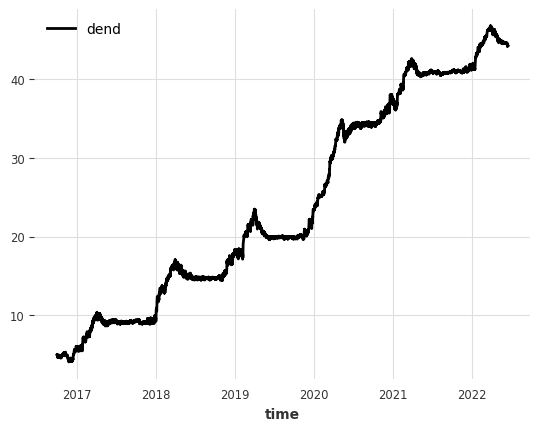

In [5]:
#| code-summary: "plot dendrometer data to check if it looks good"
fig, ax = plt.subplots()
data['dend'].plot()

The first thing is to split the dataset into a training and a validation set. We will use the first 75% of the data for training and the last 25% for validation.

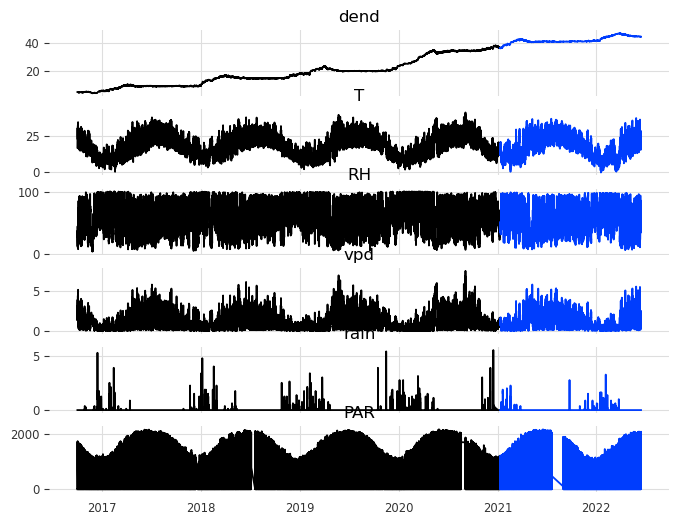

In [6]:
data_train, data_val = data.split_after(0.75)
data_jan_train, data_jan_val = data_jan.split_after(0.75)
data_jun_train, data_jun_val = data_jun.split_after(0.75)

df_train = data_train.pd_dataframe()
df_val = data_val.pd_dataframe()

fig, ax = plt.subplots(len(columns), 1, figsize=(8,len(columns)), sharex=True)
for i, column in enumerate(columns):
    ax[i].plot(df_train[column])
    ax[i].plot(df_val[column])
    ax[i].set_title(column)

Because we want to forecast the diameter of the tree, we will use the dendrometer time series as the target variable, and the other variables as features.

In [7]:
target = data_train['dend']

## ARIMA

Let's train an ARIMA model first. We will use the `AutoARIMA` class from the darts library, which will automatically choose the best parameters $(p,d,q)$ for the ARIMA model. Let's train for two different months: January and June.

In [8]:
model_arima_jan = AutoARIMA()
model_arima_jun = AutoARIMA()
model_arima_jan.fit(series=data_jan_train['dend'])
model_arima_jun.fit(series=data_jun_train['dend'])

AutoARIMA(add_encoders=None)

In [9]:
model_arima_jan.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  540
Model:               SARIMAX(2, 1, 3)   Log Likelihood                1139.615
Date:                Tue, 21 Jan 2025   AIC                          -2267.229
Time:                        10:06:56   BIC                          -2241.491
Sample:                             0   HQIC                         -2257.162
                                - 540                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9141      0.010    184.718      0.000       1.894       1.934
ar.L2         -0.9776      0.010    -95.564      0.000      -0.998      -0.958
ma.L1         -1.2687      0.039    -32.875      0.000      -1.344      -1.193
ma.L2         -0.0631      0.054     -1.173      0.241      -0.168       0.042
ma.L3          0.4285      0.036     11.744      0.000       0.357       0.500
sigma2         0.0009   3.31e-05     25.793      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               442.16
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
model_arima_jun.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  540
Model:               SARIMAX(2, 1, 0)   Log Likelihood                1705.614
Date:                Tue, 21 Jan 2025   AIC                          -3405.229
Time:                        10:06:57   BIC                          -3392.360
Sample:                             0   HQIC                         -3400.195
                                - 540                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8881      0.036     24.911      0.000       0.818       0.958
ar.L2         -0.1440      0.043     -3.320      0.001      -0.229      -0.059
sigma2         0.0001   4.27e-06     24.375      0.000    9.58e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               142.82
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
pred_ARIMA_jan = model_arima_jan.predict(n=len(data_jan_val))
pred_ARIMA_jun = model_arima_jun.predict(n=len(data_jun_val))

[Text(0.5, 0, '')]

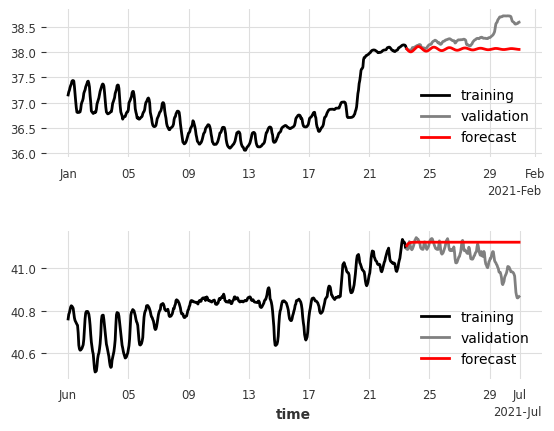

In [12]:
fig, ax = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.5) # space out the subplots
data_jan_train['dend'].plot(label='training', ax=ax[0], color="black")
data_jan_val['dend'].plot(label='validation', ax=ax[0], color="gray")
pred_ARIMA_jan.plot(label='forecast', lw=2, ax=ax[0], color="red")
ax[0].set(xlabel="")

data_jun_train['dend'].plot(label='training', ax=ax[1], color="black")
data_jun_val['dend'].plot(label='validation', ax=ax[1], color="gray")
pred_ARIMA_jun.plot(label='forecast', lw=2, ax=ax[1], color="red")
ax[0].set(xlabel="")

### future covariates

In [13]:
model_arima_jan_future = AutoARIMA()
model_arima_jun_future = AutoARIMA()

model_arima_jan_future.fit(series=data_jan_train['dend'],
                           future_covariates=data[['T', 'RH', 'vpd', 'rain', 'PAR']])
model_arima_jun_future.fit(series=data_jun_train['dend'],
                           future_covariates=data[['T', 'RH', 'vpd', 'rain', 'PAR']])

AutoARIMA(add_encoders=None)

In [14]:
pred_ARIMA_jan_future = model_arima_jan_future.predict(n=len(data_jan_val),
                                                       future_covariates=data[['T', 'RH', 'vpd', 'rain', 'PAR']])
pred_ARIMA_jun_future = model_arima_jun_future.predict(n=len(data_jun_val),
                                                       future_covariates=data[['T', 'RH', 'vpd', 'rain', 'PAR']])


<Axes: xlabel='time'>

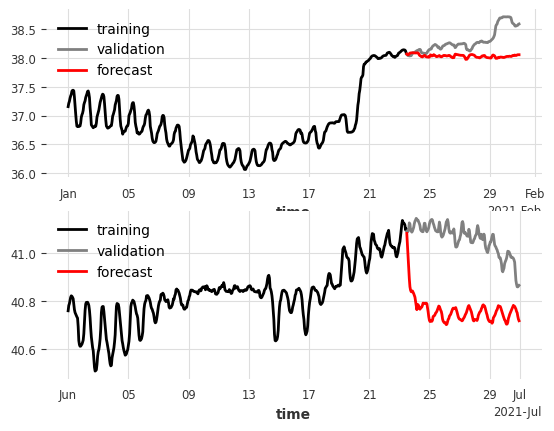

In [15]:
fig, ax = plt.subplots(2, 1)
data_jan_train['dend'].plot(label='training', ax=ax[0], color="black")
data_jan_val['dend'].plot(label='validation', ax=ax[0], color="gray")
pred_ARIMA_jan_future.plot(label='forecast', lw=2, ax=ax[0], color="red")
ax[0].legend()

data_jun_train['dend'].plot(label='training', ax=ax[1], color="black")
data_jun_val['dend'].plot(label='validation', ax=ax[1], color="gray")
pred_ARIMA_jun_future.plot(label='forecast', lw=2, ax=ax[1], color="red")

## Linear regression

The second model we will use is a linear regression. We will use the `LinearRegression` class from the `darts` library. The `lags` argument denotes the number of points in the past that we will use, and `output_chunk_length` is the number of points of the forecast.

In [16]:
#| code-summary: "define linear regression model and then train it (fit)"
model1 = LinearRegressionModel(
    lags=24*7,
    output_chunk_length=24*1
)

model1.fit(
    series=target
)

LinearRegressionModel(lags=168, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=24, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

It is quite easy to use the fitted model for forecasting. We just need to call the `predict` method, giving it the number of points `n` we want to forecast.

In [17]:
# Predict from a specific point in the target series
forecast1 = model1.predict(
    n=4000,  # Number of time steps to predict
    series=target[:],  # The target series for context
)

<Axes: xlabel='time'>

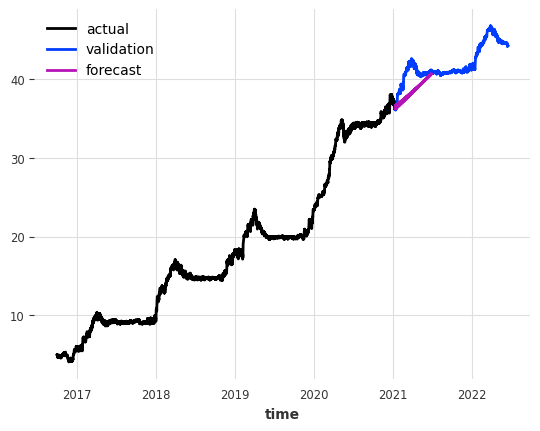

In [18]:
#| code-summary: "plot the actual, validation, and forecasted data"
fig, ax = plt.subplots()
target.plot(label='actual')
data_val['dend'].plot(label='validation')
forecast1.plot(label='forecast', lw=2)

In [19]:
#| code-summary: "function to plot forecast with running errors"
def plot_forecast_with_running_errors(
    target, forecast, validation, forecast_label="Forecast", window_sizes=[24, 72, 168, 720], extra_days=20
):
    """
    Plots the forecast, validation, and target series, along with running window errors for specified window sizes.

    Parameters:
        target (TimeSeries): The target (actual) time series.
        forecast (TimeSeries): The forecasted time series.
        validation (TimeSeries): The validation (true values) time series.
        forecast_label (str): Label for the forecast series in the plot.
        window_sizes (list of int): List of rolling window sizes (in time steps) for error calculation.
        extra_days (int): Number of days to extend the x-axis limits before and after the forecast period.
    """
    # Convert TimeSeries to pandas Series
    forecast_pd = forecast.pd_series()
    validation_pd = validation.pd_series()
    target_pd = target.pd_series()

    # Determine x-axis limits
    forecast_start = forecast.start_time()
    forecast_end = forecast.end_time()
    x_min = forecast_start - pd.Timedelta(days=extra_days)
    x_max = forecast_end + pd.Timedelta(days=extra_days)

    # Slice target and validation data for the x-axis range
    target_sliced = target_pd[x_min:x_max]
    validation_sliced = validation_pd[x_min:x_max]
    forcasted_sliced = forecast_pd[x_min:x_max]

    # print(target_sliced)
    
    # Compute rolling errors
    errors = {}
    for window in window_sizes:
        errors[window] = (
            abs((forcasted_sliced - validation_sliced) ** 2)  # Mean Squared Error (MSE)
        ).rolling(window=window, min_periods=window, center=True).mean()  # Rolling MSE

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

    # Plot the target, validation, and forecast series
    if not target_sliced.empty:
        target_sliced.plot(ax=axs[0], label="Actual", alpha=0.8)
    if not validation_sliced.empty:
        validation_sliced.plot(ax=axs[0], label="Validation", alpha=0.8)
    forecast_pd.plot(ax=axs[0], label=forecast_label, lw=2, alpha=0.8)
    axs[0].legend()
    axs[0].set_title("Target, Validation, and Forecast")
    axs[0].set_ylabel("Values")
    # axs[0].set_xlim(x_min, x_max)  # Set x-axis limits

    # Dynamically set optimal y-limits
    combined_values = pd.concat([target_sliced, validation_sliced, forecast_pd])
    if not combined_values.empty:
        y_min, y_max = combined_values.min(), combined_values.max()
        axs[0].set_ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))  # Add 10% padding

    print(errors)
    # Plot running window errors
    for window, error in errors.items():
        print(error.max())
        axs[1].plot(error, label=f"Running Error (window={window / 24:.1f} days)")
    axs[1].legend()
    axs[1].set_title("Running Window Errors")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Time")
    
    # axs[1].set_xlim(x_min, x_max)  # Set x-axis limits for errors as well

    # plt.tight_layout()
    # plt.show()


{24: time
2021-01-10 16:00:00   NaN
2021-01-10 17:00:00   NaN
2021-01-10 18:00:00   NaN
2021-01-10 19:00:00   NaN
2021-01-10 20:00:00   NaN
                       ..
2021-07-16 03:00:00   NaN
2021-07-16 04:00:00   NaN
2021-07-16 05:00:00   NaN
2021-07-16 06:00:00   NaN
2021-07-16 07:00:00   NaN
Freq: h, Name: dend, Length: 4480, dtype: float64, 72: time
2021-01-10 16:00:00   NaN
2021-01-10 17:00:00   NaN
2021-01-10 18:00:00   NaN
2021-01-10 19:00:00   NaN
2021-01-10 20:00:00   NaN
                       ..
2021-07-16 03:00:00   NaN
2021-07-16 04:00:00   NaN
2021-07-16 05:00:00   NaN
2021-07-16 06:00:00   NaN
2021-07-16 07:00:00   NaN
Freq: h, Name: dend, Length: 4480, dtype: float64, 168: time
2021-01-10 16:00:00   NaN
2021-01-10 17:00:00   NaN
2021-01-10 18:00:00   NaN
2021-01-10 19:00:00   NaN
2021-01-10 20:00:00   NaN
                       ..
2021-07-16 03:00:00   NaN
2021-07-16 04:00:00   NaN
2021-07-16 05:00:00   NaN
2021-07-16 06:00:00   NaN
2021-07-16 07:00:00   NaN
Freq: h, Na

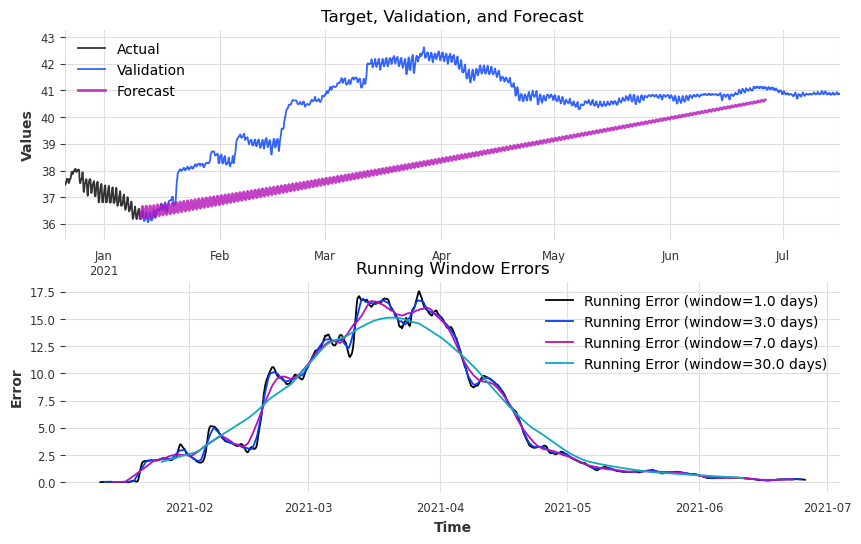

In [20]:
#| code-summary: "plot the forecast with running errors"
plot_forecast_with_running_errors(
    target=target,
    forecast=forecast1,
    validation=data_val['dend'],
    forecast_label="Forecast",
    window_sizes=[24*1, 24*3, 24*7, 24*30]  # 1 day, 3 days, 7 days, 30 days
)

### adding covariates to the model

Covariates are external variables that can help the model to make better predictions. In our case, we will use the temperature, relative humidity, rainfall, solar radiation and VPD as covariates. Also, we will use the hour, day and month as covariates.

In [21]:
#| code-summary: "define covariates"
covariates = datetime_attribute_timeseries(data, attribute="day", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(data, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    datetime_attribute_timeseries(data, attribute="hour", one_hot=False)  # Add hour
)
covariates = covariates.stack(
    data[['vpd', 'T', 'rain', 'RH', 'PAR']]  # Stack additional variables
)

# Ensure all data is in float32 format
covariates = covariates.astype(np.float32)

We can now define the model with covariates and train it. We will use one week (24*7 points) as the number of lags for the target variable, and the same number of lags for the covariates.

In [22]:
#| code-summary: "define linear regression model with covariates and then fit"
model2 = LinearRegressionModel(
    lags=24*7,
    lags_past_covariates=24*7,
    output_chunk_length=24*1
)

model2.fit(
    series=target, 
    past_covariates=covariates,
)

LinearRegressionModel(lags=168, lags_past_covariates=168, lags_future_covariates=None, output_chunk_length=24, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

We can now forecast using this second model

In [23]:
#| code-summary: "forecast with covariates"
forecast2 = model2.predict(
    n=4000,  # Number of time steps to predict
    series=target[:],  # The target series for context
    past_covariates=covariates,  # Past covariates required for prediction
)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<Axes: xlabel='time'>

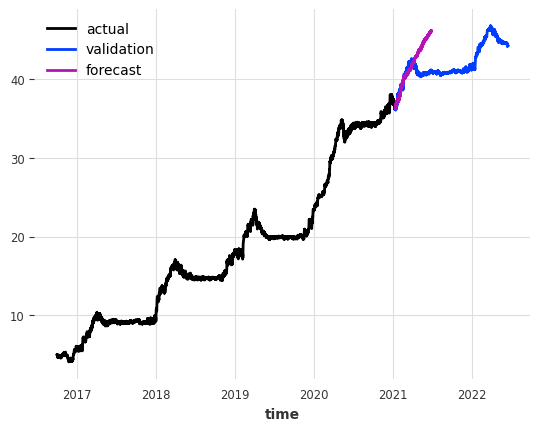

In [24]:
#| code-summary: "plot forecast with covariates"
fig, ax = plt.subplots()
target.plot(label='actual')
data_val['dend'].plot(label='validation')
forecast2.plot(label='forecast', lw=2)

{24: time
2021-01-10 16:00:00   NaN
2021-01-10 17:00:00   NaN
2021-01-10 18:00:00   NaN
2021-01-10 19:00:00   NaN
2021-01-10 20:00:00   NaN
                       ..
2021-07-16 03:00:00   NaN
2021-07-16 04:00:00   NaN
2021-07-16 05:00:00   NaN
2021-07-16 06:00:00   NaN
2021-07-16 07:00:00   NaN
Freq: h, Name: dend, Length: 4480, dtype: float64, 72: time
2021-01-10 16:00:00   NaN
2021-01-10 17:00:00   NaN
2021-01-10 18:00:00   NaN
2021-01-10 19:00:00   NaN
2021-01-10 20:00:00   NaN
                       ..
2021-07-16 03:00:00   NaN
2021-07-16 04:00:00   NaN
2021-07-16 05:00:00   NaN
2021-07-16 06:00:00   NaN
2021-07-16 07:00:00   NaN
Freq: h, Name: dend, Length: 4480, dtype: float64, 168: time
2021-01-10 16:00:00   NaN
2021-01-10 17:00:00   NaN
2021-01-10 18:00:00   NaN
2021-01-10 19:00:00   NaN
2021-01-10 20:00:00   NaN
                       ..
2021-07-16 03:00:00   NaN
2021-07-16 04:00:00   NaN
2021-07-16 05:00:00   NaN
2021-07-16 06:00:00   NaN
2021-07-16 07:00:00   NaN
Freq: h, Na

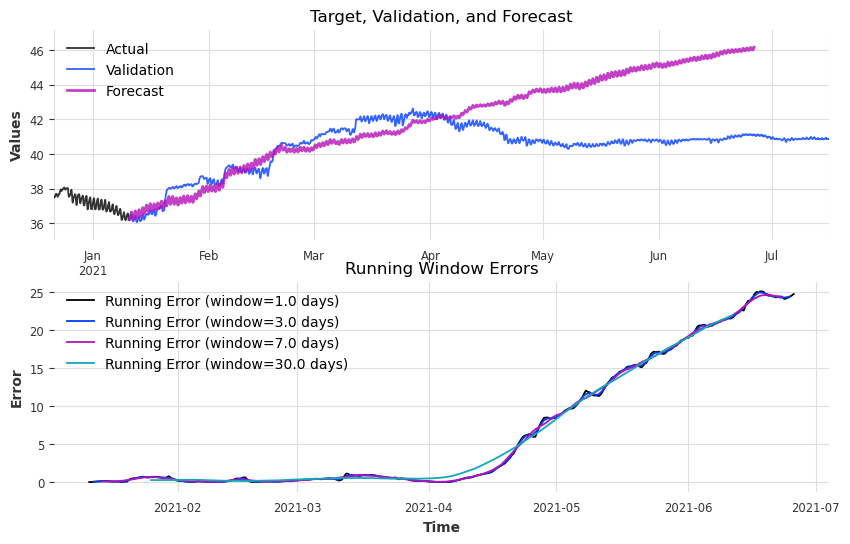

In [25]:
#| code-summary: "plot forecast with running errors"

plot_forecast_with_running_errors(
    target=target,
    forecast=forecast2,
    validation=data_val['dend'],
    forecast_label="Forecast",
    window_sizes=[24 * 1, 24 * 3, 24 * 7, 24 * 30]  # 1 day, 3 days, 7 days, 30 days
)


### future covariates as well

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


<Axes: xlabel='time'>

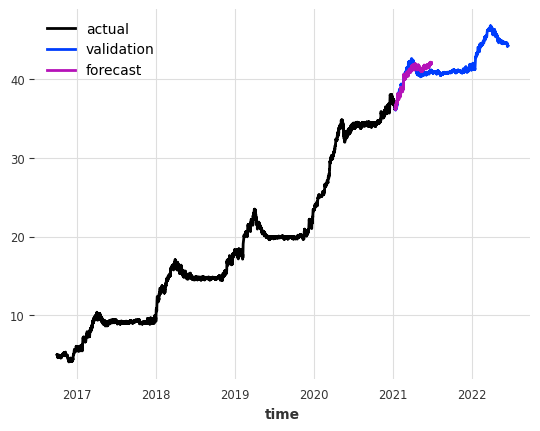

In [26]:
model3 = LinearRegressionModel(
    lags=24*7,
    lags_past_covariates=24*7,
    lags_future_covariates=list(range(0, 24*1)),
    output_chunk_length=24*1
)

model3.fit(
    series=target, 
    past_covariates=covariates,
    future_covariates=covariates
)

forecast3 = model3.predict(
    n=4000,  # Number of time steps to predict
    series=target[:],  # The target series for context
    past_covariates=covariates,  # Past covariates required for prediction
    future_covariates=covariates,  # Future covariates required for prediction
)

fig, ax = plt.subplots()
target.plot(label='actual')
data_val['dend'].plot(label='validation')
forecast3.plot(label='forecast', lw=2)

### comparison

<Axes: xlabel='time'>

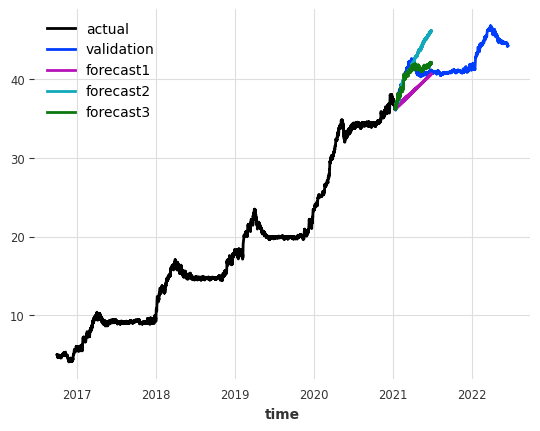

In [27]:
fig, ax = plt.subplots()
target.plot(label='actual')
data_val['dend'].plot(label='validation')
forecast1.plot(label='forecast1', lw=2)
forecast2.plot(label='forecast2', lw=2)
forecast3.plot(label='forecast3', lw=2)

### flexible prediction

We can make predictions not only of periods of time right after the training set, but actually of any period of time. Once the model has been trained, just pass  to the `predict` method target values for the period of time you want to forecast. Regarding the covariates, you can just pass the whole time series, the algorithm will take care of selecting the right values.

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


{24: time
2020-05-27 08:00:00   NaN
2020-05-27 09:00:00   NaN
2020-05-27 10:00:00   NaN
2020-05-27 11:00:00   NaN
2020-05-27 12:00:00   NaN
                       ..
2021-01-02 03:00:00   NaN
2021-01-02 04:00:00   NaN
2021-01-02 05:00:00   NaN
2021-01-02 06:00:00   NaN
2021-01-02 07:00:00   NaN
Freq: h, Name: dend, Length: 5280, dtype: float64, 72: time
2020-05-27 08:00:00   NaN
2020-05-27 09:00:00   NaN
2020-05-27 10:00:00   NaN
2020-05-27 11:00:00   NaN
2020-05-27 12:00:00   NaN
                       ..
2021-01-02 03:00:00   NaN
2021-01-02 04:00:00   NaN
2021-01-02 05:00:00   NaN
2021-01-02 06:00:00   NaN
2021-01-02 07:00:00   NaN
Freq: h, Name: dend, Length: 5280, dtype: float64, 168: time
2020-05-27 08:00:00   NaN
2020-05-27 09:00:00   NaN
2020-05-27 10:00:00   NaN
2020-05-27 11:00:00   NaN
2020-05-27 12:00:00   NaN
                       ..
2021-01-02 03:00:00   NaN
2021-01-02 04:00:00   NaN
2021-01-02 05:00:00   NaN
2021-01-02 06:00:00   NaN
2021-01-02 07:00:00   NaN
Freq: h, Na

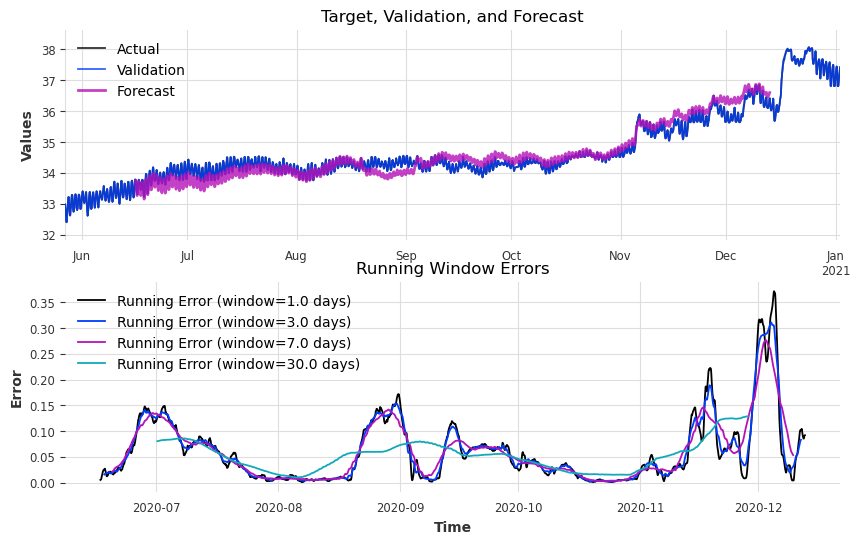

In [28]:
# example from the middle of the data:
forecast4 = model3.predict(
    n=24*180,  # Number of time steps to predict
    series=target[:-5000],  # The target series for context
    past_covariates=covariates,  # Past covariates required for prediction
    future_covariates=covariates,  # Future covariates required for prediction
)
plot_forecast_with_running_errors(
    target=target,
    forecast=forecast4,
    validation=target,
    forecast_label="Forecast",
    window_sizes=[24 * 1, 24 * 3, 24 * 7, 24 * 30]  # 1 day, 3 days, 7 days, 30 days
)